In [1]:
#ignore
from IPython.core.display import HTML,Image
import sys
sys.path.append('/anaconda/')
import config

HTML('<style>{}</style>'.format(config.CSS))


Markets are, in my view, mostly random.  However, they're not _completely_ random.  Many small inefficiencies and patterns exist in markets which can be identified and used to gain slight edge on the market.  

These edges are rarely large enough to trade in isolation - transaction costs and overhead can easily exceed the expected profits offered.  But when we are able to combine many such small edges together, the rewards can be great.  

In this article, I'll present a framework for blending together outputs from multiple models using a type of ensemble modeling known as _stacked generalization_.  This approach excels at creating models which "generalize" well to unknown future data, making them an excellent choice for the financial domain, where overfitting to past data is a major challenge.  

This post is the sixth and final installment in my tutorial series on applying machine learning to financial time series data.  If you haven't already read the prior articles, you may want to do that before starting this one.  
* [Data management](ML_data_management.html)
* [Feature engineering](feature_engineering.html)
* [Feature selection](feature_selection.html)
* [Walk-forward modeling](walk_forward_model_building.html)
* [Model evaluation](model_evaluation.html)

### Ensemble Learning 

_Ensemble learning_ is a powerful - and widely used - technique for improving model performance (especially it's _generalization_) by combining predictions made by multiple different machine learning models.  The idea behind ensemble learning is not dissimilar from the concept ["wisdom of the crowd"](https://en.wikipedia.org/wiki/Wisdom_of_the_crowd), which posits that the aggregated/consensus answer of several diverse, well-informed individuals is typically better than any one individual within the group.  

In the world of machine learning, this concept of combining multiple models takes many forms.  The first form appears _within_ a number of commonly used algorithms such as [Random Forests](https://en.wikipedia.org/wiki/Random_forest), [Bagging](https://en.wikipedia.org/wiki/Bootstrap_aggregating), and [Boosting](https://en.wikipedia.org/wiki/Boosting_(machine_learning) (though this one works somewhat differently).  Each of these algorithms takes a single base model (e.g., a decision tree) and trains many versions of that single algorithm on differing sets of features or samples.  The resulting collection of trained models are often more robust out of sample because they're likely to be less overfitted to certain features or samples in the training data.

A second form of ensembling methods involves aggregating across multiple _different model types_ (e.g., an SVM, a logistic regression, and a decision tree) - or with _different hyperparameters_.  Since each learning algorithm or set of hyperparameters tends to have different biases, it will tend to make different prediction errors - and extract different signals - from the same set of data.  Assuming all models are reasonably good - and that the errors are reasonably uncorrelated to one another - they will partially cancel each other out and the aggregated predictions will be more useful than any single model's predictions.  

One particularly flexible approach to this latter type of ensemble modeling is "stacked generalization", or "stacking".  In this post, I will walk through a simple example of stacked generalization applied to time series data.  If you'd like to replicate and experiment with the below code, _you can download the source notebook for this post by right-clicking on the below button and choosing "save link as"_ 

<a style="text-align: center;" href="https://github.com/convergenceIM/alpha-scientist/blob/master/content/06_Ensemble_Modeling.ipynb"><img src="images/button_ipynb-notebook.png" title="download ipynb" /></a>



### Overview of Stacked Generalization 
The "stacked generalization" framework was initially proposed by Wolpert in a [1992 academic paper](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.56.1533).  Since it was first proposed, stacked generalization (aka "stacking") has received a modest but consistent amount of attention from the ML research community.  

Stacked generalization is an ensemble modeling technique.  The core concept of stacked generalization is to generate a single, optimally robust prediction for a regression or classification task by (a) building multiple different models (with varying learning algorithms, varying hyperparameters, and/or different features) to make predictions then (b) training a "meta-model" or "blending model" to determine how to combine the predictions of each of these multiple models.  

A nice way to visualize this (borrowed from documentation for Sebastian Rashka's excellent [mlxtend package](http://rasbt.github.io/mlxtend/user_guide/regressor/StackingRegressor/)) is shown below.  Each model R<sub>1</sub> thru R<sub>m</sub> is trained on historical data and used to make predictions P<sub>1</sub> thru P<sub>m</sub>.  Those predictions then become the features used to train a meta-model to determine how to combine these predictions.  


<img src="http://rasbt.github.io/mlxtend/user_guide/regressor/StackingRegressor_files/stackingregression_overview.png" width="400">

I think of this using an analogy. Imagine that there is a team of investment analysts whose manager has asked each of them to make earnings forecasts for the same set of companies across many quarters.  The manager "learns" which analysts have historically been most accurate, somewhat accurate, and inaccurate.  When future predictions are needed, the manager can assign greater and lesser (and in some cases, zero) weighting to each analyst's prediction.

It's clear why it's referred to as "stacked".  But why "generalization"?  The principal motivation for applying this technique is to achieve greater "generalization" of models to out-of-sample (i.e., unseen) data by de-emphasizing models which appear to be overfitted to the data.  This is achieved by allowing the meta-model to learn which of the base models' predictions have held up well (and poorly) out-of-sample and to weight models appropriately.  


### Motivations
In my view, stacked generalization is perfectly suited to the challenges we face when making predictions in noisy, non-stationary, regime-switching financial markets.  When properly implemented (see next section), stacking help to defend against the scourge of overfitting - something which virtually all practitioners of investing ML will agree is a major challenge.  

Better yet, stacking allows us to blend together relatively weak (but orthogonal and additive) signals together in a way that doesn't get drowned out by stronger signals.  

To illustrate, consider a canonical trend-following strategy which is predicated on 12 month minus 1 month price change.  Perhaps we also believe that month-of-year or recent IBIS earnings trend have a weak, but still useful effect on price changes.  If we were to train a model that lumped together dominant features (12 minus 1 momentum) and weaker features (seasonality or IBIS trend), our model may miss the subtle information because the dominant features overshadow them. 

A stacked model, which has one component (i.e., a base model) focused on solely momentum features, another component focused on solely seasonality features, and a third one focused on analyst revisions features can capture and use the more subtle effects alongside the more dominant momentum effect.


### Keys to Success
Stacked generalization is sometimes referred to as a "black art" and there is truth to that view.  However, there are also two concrete principles that will get you a long way towards robust results.

__1. Out of Sample Training__  
First, it's _absolutely critical_ that the predictions P<sub>1</sub> thru P<sub>m</sub> used to train the meta-model are exclusively _out of sample_ predictions.  Why?  Because in order to determine which models are likely to generalize best to out of sample (ie those with least overfit), we must judge that based on past predictions which were themselves made out-of-sample.  

Imagine that you trained two models using different algorithms, say logistic regression and decision trees.  Both could be very useful (out of sample) but decision trees have a greater tendency to overfit training data.  If we used in-sample predictions as features to our meta-learner, we'd likely give much more weight to the model with a tendancy to overfit the most.  

Several methods can be used for this purpose.  Some advise splitting training data into Train<sub>1</sub> and Train<sub>2</sub> sets so base models can be trained on Train<sub>1</sub> and then can make predictions on Train<sub>2</sub> data for use in training the ensemble model.  Predictions of the ensemble model must, of course, be evaluated on yet another dataset.    

Others use K-fold cross-validation prediction (such as scikit's `cross_val_predict`) on base models to simulate out-of-sample(ish) predictions to feed into the ensemble layer.  

However, in my view, the best method for financial time series data is to use walk-forward training and prediction on the base models, as described in my [Walk-forward modeling](walk_forward_model_building.html) post.  In addition to ensuring that every base prediction is true out-of-sample, it simulates the impact of non-stationarity (a.k.a. regime change) over time.     

__2. Non-Negativity__  
Second - and this is less of a hard-and-fast rule - is to constrain the meta-model to learning non-negative coefficients only, using an algorithm like ElasticNet or lasso which allows non-negativity constraints.  

This technique is important because quite often (and sometimes by design) there will be very high collinearity of the "features" fed into the meta-model (P<sub>1</sub> thru P<sub>m</sub>).  In periods of high collinearity, learning algorithms can do funky things, such as finding a slightly better fit to past data by assigning a high positive coefficient to one model and a large negative coefficient to another.  This is rarely what we really want.  

Call me crazy, but if a model is useful only in that it consistently predicts the wrong outcome, it's probably not a model I want to trust.  



### Further Reading
That's enough (too much?) background for now.  Those interested in more about the theory and practice of stacked generalization should check out the below research papers:
* [Wolpert, 1992](http://www.machine-learning.martinsewell.com/ensembles/stacking/Wolpert1992.pdf)
* [Ting and Witten, 1997](https://pdfs.semanticscholar.org/fd97/e40ef6c310213fae017fdbf328c8bdf5cb68.pdf)
* [Ting and Witten, 1999](https://arxiv.org/pdf/1105.5466.pdf)
* [Breiman, 1996](https://link.springer.com/content/pdf/10.1007/BF00117832.pdf)
* [Sigletos et al, 2005](http://www.jmlr.org/papers/volume6/sigletos05a/sigletos05a.pdf)
* [Why do stacked ensemble models win data science competitions?](https://blogs.sas.com/content/subconsciousmusings/2017/05/18/stacked-ensemble-models-win-data-science-competitions/)


## Preparing the Data
For this simple example, I will create synthetic data rather than using real market prices to remove the ambiguity about what features and transformations may be necessary to extract maximum value from the model.  

Note: to make the dataset more realistic, I will extract an _index_ from actual stock prices using quandl's API, but all features and target values will be constructed below.  

With index in hand, we will generate four "hidden factors".  These are the non-random drivers of the target variable, and are the "signal" we ideally want to learn.  

To ensure that these factors are meaningful, we will _create the target variable (`y`) using combinations of these factors_.  The first two hidden factors have a __linear__ relationship to the target.  The second two hidden factors have a more complex relationship involving interaction effects between variables.  Lastly, we will add a noise component to make our learners work for it.  

Finally, we'll create several features that are each related to one or more hidden factors, including generous amounts of noise and bias. 

Key point: we've created X and y data which we know is related by several different linkages, some of which are linear and some of which aren't.  This is what our modeling will seek to learn.  

In [2]:
import numpy as np
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like # remove once updated pandas-datareader issue is fixed
# https://github.com/pydata/pandas-datareader/issues/534
import pandas_datareader.data as web
%matplotlib inline

from IPython.core.display import HTML,Image
HTML('<style>{}</style>'.format(config.CSS))


def get_symbols(symbols,data_source, begin_date=None,end_date=None):
    out = pd.DataFrame()
    for symbol in symbols:
        df = web.DataReader(symbol, data_source,begin_date, end_date)[['AdjOpen','AdjHigh','AdjLow','AdjClose','AdjVolume']].reset_index()
        df.columns = ['date','open','high','low','close','volume'] #my convention: always lowercase
        df['symbol'] = symbol # add a new column which contains the symbol so we can keep multiple symbols in the same dataframe
        df = df.set_index(['date','symbol'])
        out = pd.concat([out,df],axis=0) #stacks on top of previously collected data
    return out.sort_index()
        
idx = get_symbols(['AAPL','CSCO','MSFT','INTC'],data_source='quandl',begin_date='2012-01-01',end_date=None).index
# note, we're only using quandl prices to generate a realistic multi-index of dates and symbols

num_obs = len(idx)
split = int(num_obs*.80)

## First, create factors hidden within feature set
hidden_factor_1 = pd.Series(np.random.randn(num_obs),index=idx)
hidden_factor_2 = pd.Series(np.random.randn(num_obs),index=idx)
hidden_factor_3 = pd.Series(np.random.randn(num_obs),index=idx)
hidden_factor_4 = pd.Series(np.random.randn(num_obs),index=idx)

## Next, generate outcome variable y that is related to these hidden factors
y = (0.5*hidden_factor_1 + 0.5*hidden_factor_2 +  # factors linearly related to outcome
     hidden_factor_3 * np.sign(hidden_factor_4) + hidden_factor_4*np.sign(hidden_factor_3)+ # factors with non-linear relationships
      pd.Series(np.random.randn(num_obs),index=idx)).rename('y') # noise

## Generate features which contain a mix of one or more hidden factors plus noise and bias

f1 = 0.25*hidden_factor_1  +  pd.Series(np.random.randn(num_obs),index=idx) + 0.5
f2 = 0.5*hidden_factor_1  +  pd.Series(np.random.randn(num_obs),index=idx) - 0.5
f3 = 0.25*hidden_factor_2  +  pd.Series(np.random.randn(num_obs),index=idx) + 2.0
f4 = 0.5*hidden_factor_2  +  pd.Series(np.random.randn(num_obs),index=idx) - 2.0
f5 = 0.25*hidden_factor_1 + 0.25*hidden_factor_2  +  pd.Series(np.random.randn(num_obs),index=idx) 
f6 = 0.25*hidden_factor_3  +  pd.Series(np.random.randn(num_obs),index=idx) + 0.5
f7 = 0.5*hidden_factor_3  +  pd.Series(np.random.randn(num_obs),index=idx) - 0.5
f8 = 0.25*hidden_factor_4  +  pd.Series(np.random.randn(num_obs),index=idx) + 2.0
f9 = 0.5*hidden_factor_4  +  pd.Series(np.random.randn(num_obs),index=idx) - 2.0
f10 = hidden_factor_3 + hidden_factor_4  +  pd.Series(np.random.randn(num_obs),index=idx) 

## From these features, create an X dataframe
X = pd.concat([f1.rename('f1'),f2.rename('f2'),f3.rename('f3'),f4.rename('f4'),f5.rename('f5'),
               f6.rename('f6'),f7.rename('f7'),f8.rename('f8'),f9.rename('f9'),f10.rename('f10')],axis=1)


### Exploratory Data Analysis
We'll avoid going too deeply into exploratory data analysis (refer to [Feature engineering](feature_engineering.html) for more exploration of that topic).  I will, however, plot three simple views:
1. Distributions of the features and target variables.
2. Simple univariate regressions for each of the ten features vs. the target variable.  
3. A clustermap showing correlations between the features (see [Feature selection](feature_selection.html) for more on this technique):

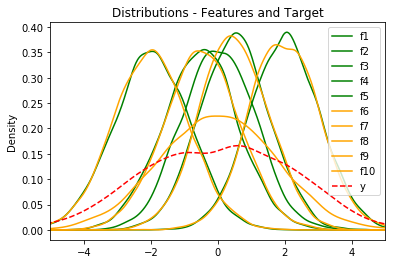

In [3]:
## Distribution of features and target
X.plot.kde(legend=True,xlim=(-5,5),color=['green']*5+['orange']*5,title='Distributions - Features and Target')
y.plot.kde(legend=True,linestyle='--',color='red') # target

Text(0.5, 1.05, 'Univariate Regressions for Features')

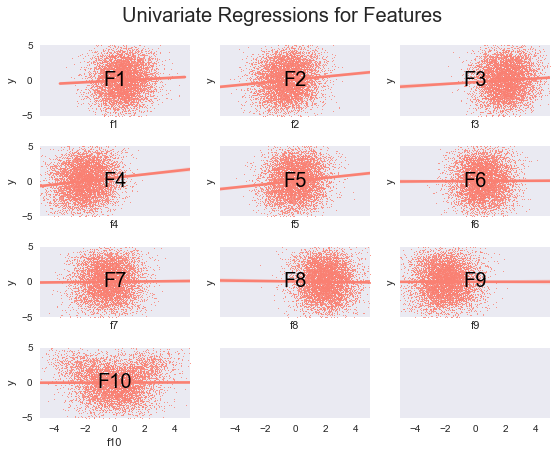

In [4]:
## Univariate Regressions

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="dark")

# Set up the matplotlib figure
fig, axes = plt.subplots(4, 3, figsize=(8, 6), sharex=True, sharey=True)

# Rotate the starting point around the cubehelix hue circle
for ax, s in zip(axes.flat, range(10)):
    cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)
    x = X.iloc[:,s]
    sns.regplot(x, y,fit_reg = True, marker=',', scatter_kws={'s':1},ax=ax,color='salmon')
    ax.set(xlim=(-5, 5), ylim=(-5, 5))
    ax.text(x=0,y=0,s=x.name.upper(),color='black',
            **{'ha': 'center', 'va': 'center', 'family': 'sans-serif'},fontsize=20)

fig.tight_layout()
fig.suptitle("Univariate Regressions for Features", y=1.05,fontsize=20)


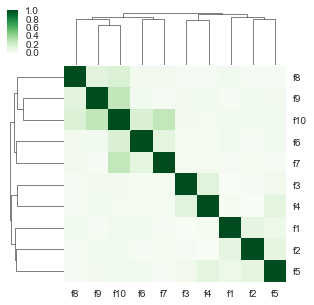

In [5]:
## Feature correlations

from scipy.cluster import hierarchy
from scipy.spatial import distance

corr_matrix = X.corr()
correlations_array = np.asarray(corr_matrix)
linkage = hierarchy.linkage(distance.pdist(correlations_array), \
                            method='average')
g = sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage,\
                   row_cluster=True,col_cluster=True,figsize=(5,5),cmap='Greens',center=0.5)
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()
label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns


## Making Base Models

The first step in a stacked generalization system is to generate the "base models", meaning the models which are learning from our input features.  We'll create two base models to use in our ensemble:
1. A collection of simple linear regression models 
2. A collection of tree models - in this case, using the ExtraTrees algorithm 

As described above _it's absolutely critical_ to build models which provide realistic _out-of-sample_ predictions, I am going to apply the methodology presented in [Walk-forward modeling](walk_forward_model_building.html).  In short, this will retrain at the end of each calendar quarter, using only data which would have been available at that time.  Predictions are made using the most recently trained model.  

To make this easier to follow, I'll define a simple function called `make_walkforward_model` that trains a series of models at various points in time and generates out of sample predictions using those trained models.

In [6]:
from sklearn.base import clone
from sklearn.linear_model import LinearRegression


def make_walkforward_model(features,outcome,algo=LinearRegression()):
    recalc_dates = features.resample('Q',level='date').mean().index.values[:-1]
    
    ## Train models
    models = pd.Series(index=recalc_dates)
    for date in recalc_dates:    
        X_train = features.xs(slice(None,date),level='date',drop_level=False)
        y_train = outcome.xs(slice(None,date),level='date',drop_level=False)
        #print(f'Train with data prior to: {date} ({y_train.count()} obs)')
        
        model = clone(algo)
        model.fit(X_train,y_train)
        models.loc[date] = model

    begin_dates = models.index
    end_dates = models.index[1:].append(pd.to_datetime(['2099-12-31']))

    ## Generate OUT OF SAMPLE walk-forward predictions
    predictions = pd.Series(index=features.index)
    for i,model in enumerate(models): #loop thru each models object in collection
        #print(f'Using model trained on {begin_dates[i]}, Predict from: {begin_dates[i]} to: {end_dates[i]}')
        X = features.xs(slice(begin_dates[i],end_dates[i]),level='date',drop_level=False)
        p = pd.Series(model.predict(X),index=X.index)
        predictions.loc[X.index] = p
    
    return models,predictions

To create a series of walk-forward models, simply pass in X and y data along with a scikit estimator object.  It returns a series of models and a series of predictions.  Here, we'll create two base models on all features, one using linear regression and one with extra trees.

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor

linear_models,linear_preds = make_walkforward_model(X,y,algo=LinearRegression())
tree_models,tree_preds = make_walkforward_model(X,y,algo=ExtraTreesRegressor())

Note that no predictions can be made prior to the first trained model, so it's important to `dropna()` on predictions prior to use.  

In [8]:
print("Models:")
print(linear_models.head())
print()
print("Predictions:")
print(linear_preds.dropna().head())

Models:
2012-03-31    LinearRegression(copy_X=True, fit_intercept=Tr...
2012-06-30    LinearRegression(copy_X=True, fit_intercept=Tr...
2012-09-30    LinearRegression(copy_X=True, fit_intercept=Tr...
2012-12-31    LinearRegression(copy_X=True, fit_intercept=Tr...
2013-03-31    LinearRegression(copy_X=True, fit_intercept=Tr...
dtype: object

Predictions:
date        symbol
2012-04-02  AAPL     -0.786846
            CSCO     -1.518537
            INTC      0.145496
            MSFT     -0.677892
2012-04-03  AAPL      0.403579
dtype: float64


It can be instructive to see how the linear model coefficients evolve over time:

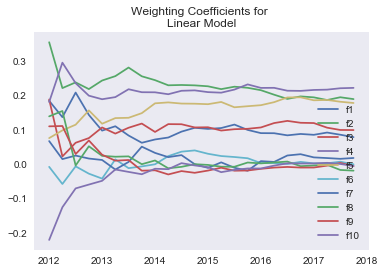

In [9]:
pd.DataFrame([model.coef_ for model in linear_models],
             columns=X.columns,index=linear_models.index).plot(title='Weighting Coefficients for \nLinear Model')

Next, I'll create a simple function to evaluate multiple model performance metrics, called `calc_scorecard`.  Further detail on this method of model evaluation is provided in the earlier post [Model evaluation](model_evaluation.html).  

In [10]:
from sklearn.metrics import r2_score,mean_absolute_error

def calc_scorecard(y_pred,y_true):
    
    def make_df(y_pred,y_true):
        y_pred.name = 'y_pred'
        y_true.name = 'y_true'

        df = pd.concat([y_pred,y_true],axis=1).dropna()

        df['sign_pred'] = df.y_pred.apply(np.sign)
        df['sign_true'] = df.y_true.apply(np.sign)
        df['is_correct'] = 0
        df.loc[df.sign_pred * df.sign_true > 0 ,'is_correct'] = 1 # only registers 1 when prediction was made AND it was correct
        df['is_incorrect'] = 0
        df.loc[df.sign_pred * df.sign_true < 0,'is_incorrect'] = 1 # only registers 1 when prediction was made AND it was wrong
        df['is_predicted'] = df.is_correct + df.is_incorrect
        df['result'] = df.sign_pred * df.y_true 
        return df
    
    df = make_df(y_pred,y_true)
    
    scorecard = pd.Series()
    # building block metrics
    scorecard.loc['RSQ'] = r2_score(df.y_true,df.y_pred)
    scorecard.loc['MAE'] = mean_absolute_error(df.y_true,df.y_pred)
    scorecard.loc['directional_accuracy'] = df.is_correct.sum()*1. / (df.is_predicted.sum()*1.)*100
    scorecard.loc['edge'] = df.result.mean()
    scorecard.loc['noise'] = df.y_pred.diff().abs().mean()
    # derived metrics
    scorecard.loc['edge_to_noise'] = scorecard.loc['edge'] / scorecard.loc['noise']
    scorecard.loc['edge_to_mae'] = scorecard.loc['edge'] / scorecard.loc['MAE']
    return scorecard    

calc_scorecard(y_pred=linear_preds,y_true=y).rename('Linear')

RSQ                      0.027760
MAE                      1.784532
directional_accuracy    53.788634
edge                     0.278431
noise                    0.530620
edge_to_noise            0.524727
edge_to_mae              0.156024
Name: Linear, dtype: float64

Since we are concerned about not only average performance but also period-to-period consistency, I'll create a simple wrapper function which recalculates our metrics by quarter.  

date                  2016-12-31  2017-12-31  2018-12-31
RSQ                     0.028539    0.017950   -0.006912
MAE                     1.777784    1.726196    1.779631
directional_accuracy   55.853175   52.104208   53.813559
edge                    0.274354    0.254843    0.254830
noise                   0.514929    0.502813    0.503823
edge_to_noise           0.532799    0.506835    0.505792
edge_to_mae             0.154323    0.147633    0.143193


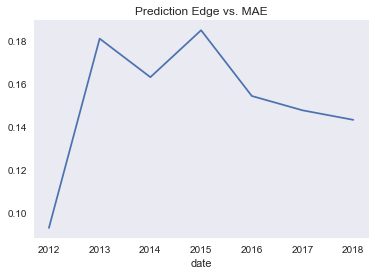

In [11]:
def scores_over_time(y_pred,y_true):
    df = pd.concat([y_pred,y_true],axis=1).dropna().reset_index().set_index('date')
    scores = df.resample('A').apply(lambda df: calc_scorecard(df[y_pred.name],df[y_true.name]))
    return scores

scores_by_year = scores_over_time(y_pred=linear_preds,y_true=y)
print(scores_by_year.tail(3).T)
scores_by_year['edge_to_mae'].plot(title='Prediction Edge vs. MAE')

## Making the Ensemble Model
Now that we've trained base models and generated out-of-sample predictions, it's time to train the stacked generalization ensemble model.  

Training the ensemble model simply requires feeding in the base models' predictions in as the X dataframe.  To clean up the data and ensure the X and y are of compatible dimensions, I've created a short data preparation function.   

Here, we'll use Lasso to train the ensemble becuase it is one of a few linear models which can be constrained to `positive = True`.  This will ensure that the ensemble will assign either a positive or zero weight to each model, for reasons described above. 

In [12]:
from sklearn.linear_model import LassoCV
def prepare_Xy(X_raw,y_raw):
    ''' Utility function to drop any samples without both valid X and y values'''
    Xy = X_raw.join(y_raw).replace({np.inf:None,-np.inf:None}).dropna()
    X = Xy.iloc[:,:-1]
    y = Xy.iloc[:,-1]
    return X,y
X_ens, y_ens = prepare_Xy(X_raw=pd.concat([linear_preds.rename('linear'),tree_preds.rename('tree')],
                                          axis=1),y_raw=y)

ensemble_models,ensemble_preds = make_walkforward_model(X_ens,y_ens,algo=LassoCV(positive=True))
ensemble_preds = ensemble_preds.rename('ensemble')
print(ensemble_preds.dropna().head())

date        symbol
2012-07-02  AAPL      0.464468
            CSCO      0.238618
            INTC     -0.008967
            MSFT      0.864243
2012-07-03  AAPL      0.437890
Name: ensemble, dtype: float64


Note that the ensemble's predictions don't begin until July, since the earliest trained ensemble model isn't available until end of Q2.  This is necessary to make sure the ensemble model is trained on out of sample data - and that its predictions are _also_ out of sample.  

Again, we can look at the coefficients over time of the ensemble model. Keep in mind that the coefficients of the ensemble model represents how much weight is being given to each base model.  In this case, it appears that our tree model is much more useful relative to the linear model, though the linear model is gradually catching up.  

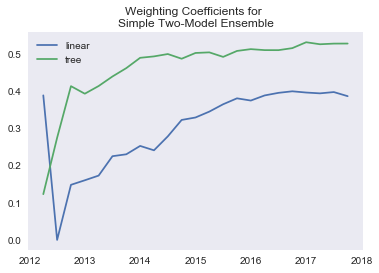

In [13]:
pd.DataFrame([model.coef_ for model in ensemble_models],
             columns=X_ens.columns,index=ensemble_models.index).plot(title='Weighting Coefficients for \nSimple Two-Model Ensemble')

## Performance of Ensemble vs. Base Models

Now that we have predictions from both the base models and ensemble model, we can explore how the ensemble performs relative to base models.  Is the whole really more than the sum of the parts?

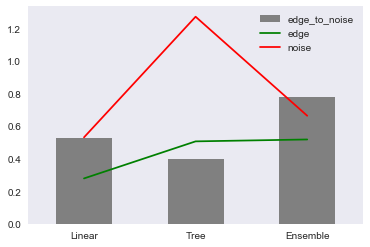

                         Linear       Tree   Ensemble
RSQ                    0.027760   0.045876   0.099376
MAE                    1.784532   1.719567   1.703933
directional_accuracy  53.788634  59.538053  59.417274
edge                   0.278431   0.505890   0.517530
noise                  0.530620   1.270888   0.663137
edge_to_noise          0.524727   0.398060   0.780427
edge_to_mae            0.156024   0.294196   0.303727


In [14]:
# calculate scores for each model
score_ens = calc_scorecard(y_pred=ensemble_preds,y_true=y_ens).rename('Ensemble')
score_linear = calc_scorecard(y_pred=linear_preds,y_true=y_ens).rename('Linear')
score_tree = calc_scorecard(y_pred=tree_preds,y_true=y_ens).rename('Tree')


scores = pd.concat([score_linear,score_tree,score_ens],axis=1)
scores.loc['edge_to_noise'].plot.bar(color='grey',legend=True)
scores.loc['edge'].plot(color='green',legend=True)
scores.loc['noise'].plot(color='red',legend=True)

plt.show()
print(scores)


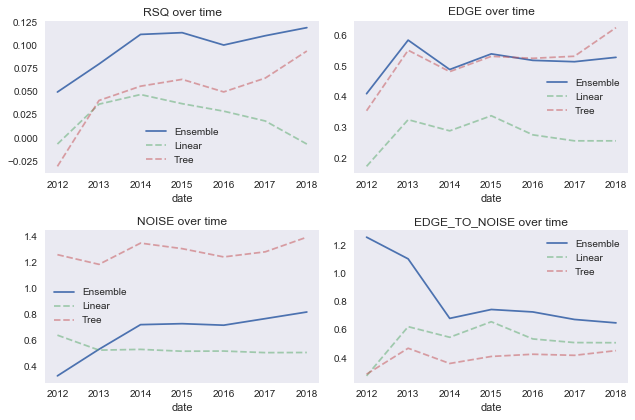

In [15]:
fig,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(9,6))
metric = 'RSQ'
scores_over_time(y_pred=ensemble_preds.rename('ensemble'),y_true=y)[metric].rename('Ensemble').\
plot(title=f'{metric.upper()} over time',legend=True,ax=ax1)
scores_over_time(y_pred=linear_preds.rename('linear'),y_true=y)[metric].rename('Linear').\
plot(title=f'{metric.upper()} over time',legend=True, alpha = 0.5, linestyle='--',ax=ax1)
scores_over_time(y_pred=tree_preds.rename('tree'),y_true=y)[metric].rename("Tree").\
plot(title=f'{metric.upper()} over time',legend=True, alpha = 0.5, linestyle='--',ax=ax1)

metric = 'edge'
scores_over_time(y_pred=ensemble_preds.rename('ensemble'),y_true=y)[metric].rename('Ensemble').\
plot(title=f'{metric.upper()} over time',legend=True,ax=ax2)
scores_over_time(y_pred=linear_preds.rename('linear'),y_true=y)[metric].rename('Linear').\
plot(title=f'{metric.upper()} over time',legend=True, alpha = 0.5, linestyle='--',ax=ax2)
scores_over_time(y_pred=tree_preds.rename('tree'),y_true=y)[metric].rename("Tree").\
plot(title=f'{metric.upper()} over time',legend=True, alpha = 0.5, linestyle='--',ax=ax2)

metric = 'noise'
scores_over_time(y_pred=ensemble_preds.rename('ensemble'),y_true=y)[metric].rename('Ensemble').\
plot(title=f'{metric.upper()} over time',legend=True,ax=ax3)
scores_over_time(y_pred=linear_preds.rename('linear'),y_true=y)[metric].rename('Linear').\
plot(title=f'{metric.upper()} over time',legend=True, alpha = 0.5, linestyle='--',ax=ax3)
scores_over_time(y_pred=tree_preds.rename('tree'),y_true=y)[metric].rename("Tree").\
plot(title=f'{metric.upper()} over time',legend=True, alpha = 0.5, linestyle='--',ax=ax3)

metric = 'edge_to_noise'
scores_over_time(y_pred=ensemble_preds.rename('ensemble'),y_true=y)[metric].rename('Ensemble').\
plot(title=f'{metric.upper()} over time',legend=True,ax=ax4)
scores_over_time(y_pred=linear_preds.rename('linear'),y_true=y)[metric].rename('Linear').\
plot(title=f'{metric.upper()} over time',legend=True, alpha = 0.5, linestyle='--',ax=ax4)
scores_over_time(y_pred=tree_preds.rename('tree'),y_true=y)[metric].rename("Tree").\
plot(title=f'{metric.upper()} over time',legend=True, alpha = 0.5, linestyle='--',ax=ax4)

plt.tight_layout()
plt.show()

### Observations:
* We can see that the ensemble is fairly consistently more effective than either of the base models. 
* All models seem to be getting better over time (and as they have more data on which to train).  
* The ensemble also appears to be a bit more consistent over time.  Much like a diversified portfolio of stocks should be less volatile than the individual stocks within it, an ensemble of diverse models will often perform more consistently across time

## Next Steps
The stacked generalization methodology is highly flexible.  There are countless directions you can take this, including:
* __More model types__: add SVMs, deep learning models, regularlized regressions, and dimensionality reduction models to the mix
* __More hyperparameter combinations__: try multiple sets of hyperparameters on a particular algorithm.
* __Orthogonal feature sets__: try training base models on different subsets of features.  Avoid the "curse of dimensionality" by limiting each base model to an appropriately small number of features.  

## Summary

This final post, combined with the five previous posts, presents an end-to-end framework for applying supervised machine learning techniques to financial time series data, in a way which helps mitigate the several unique challenges of this domain.  

* [Data management](ML_data_management.html)
* [Feature engineering](feature_engineering.html)
* [Feature selection](feature_selection.html)
* [Walk-forward modeling](walk_forward_model_building.html)
* [Model evaluation](model_evaluation.html)

Please feel free to add to the comment section with your comments and questions on this post.  I'm also interested in ideas for future posts.  

Going forward, I plan to shift gears from tutorials to research on market anomalies and trading opportunities. 

## One more thing...
If you've found this post useful, please consider subscribing to the email list to be notified of future posts (email addresses will only be used for this purpose...).  

You can also follow me on [twitter](https://twitter.com/data2alpha) and forward to a friend or colleague who may find this topic interesting.  